Давайте попробуем поизучать сезонность торговых инстументов.
Возьмем, например, EURUSD
Экспортируем из метатрейдера дневной график, он там доступен с ноября 2002 года. 
В принципе, можно экспортировать любой ТФ, но для анализа сезонности нам должно быть достаточно дневных движений
Разметим колонки в файле, как DATE, TIME, OPEN, HIGH, LOW, CLOSE, VOLUME - именно в таком порядке данные расположены в файле выдачи экспорта истории метатрейдера.
Давайте зачитаем его в табличку:

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

df = pd.read_csv('Dukascopy-AUDNZD-2006.12.12-2025.02.05-bardata_D1.csv',
                 sep=',',
                 header=0,
                 dtype={
                     'Open': np.float64,
                     'High': np.float64,
                     'Low': np.float64,
                     'Close': np.float64},
                 encoding='utf-8',
                 parse_dates=['Date'],
                 date_format='%Y.%m.%d').set_index('Date') 
df.head(5)

,Open,High,Low,Close
Date,,,,
2006-12-12,1.13948,1.14106,1.13410,1.13454
2006-12-13,1.13449,1.14130,1.13381,1.13407
2006-12-14,1.13389,1.14064,1.13018,1.13586
2006-12-15,1.13592,1.13740,1.12985,1.13151
2006-12-18,1.13183,1.13464,1.12687,1.12863


Нам не очень нужны все эти колонки для анализа.
Все, что нам нужно - это величина тела свечи, положительная для бычьих свечей и отрицательная - для медвежьих.
Для чистоты данных, мы будем считать тело свечи, как разницу между предыдущим и текущим закрытием.
Попутно вычистим неполные годы. Для порядку.

In [2]:
# Calculate the difference between consecutive CLOSE values
df['MOVE'] = df['Close'].diff()
# Handle the first row
df.loc[df.index[0], 'MOVE'] = df.loc[df.index[0], 'Close'] - df.loc[df.index[0], 'Open']

# Get the start and end years
start_year = df.index[0].year
end_year = df.index[-1].year

# Check if the start date is after January 10th
if df.index[0] > datetime(start_year, 1, 10):
    start_year += 1

# Check if the end date is before December 20th
if df.index[-1] < datetime(end_year, 12, 20):
    end_year -= 1

# Truncate the dataframe
df_trimmed = df[['MOVE']].copy().truncate(before=datetime(start_year, 1, 1), after=datetime(end_year, 12, 31))

df_trimmed.head(5)

,MOVE
Date,
2007-01-02,0.00882
2007-01-03,-0.00648
2007-01-04,0.00331
2007-01-05,0.01068
2007-01-08,-0.00230


Стало гораздо приятнее, правда?
Нарисуем это добро на графичке:

Matplotlib is building the font cache; this may take a moment.


<Axes: xlabel='Date'>

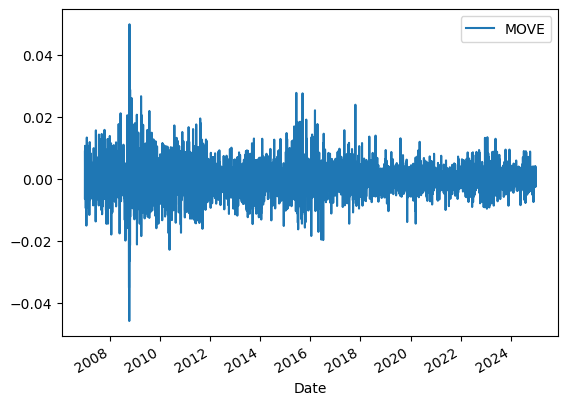

In [3]:
import matplotlib
df_trimmed.plot()

Теперь нам нужно порезать это все на месяцы (чтобы данные одного месяца не сравнивать с данными другого месяца в разные годы, что может случиться за счет разного рода выходных) и сгруппировать по годам:

In [4]:
years = df_trimmed.index.year.unique()
new_index = pd.date_range(start=f'{min(years)}-01-01', end=f'{max(years)}-12-31', freq='D')
df_reindexed = df_trimmed.reindex(new_index).fillna(0.0)
pivot_by_year = df_reindexed.pivot_table(
    index=[df_reindexed.index.month, df_reindexed.index.day],
    columns=df_reindexed.index.year, 
    values='MOVE',
    aggfunc='first').fillna(0.0)  # this fillna is for aligning with leap year
pivot_by_year.head(10)

2007     2008     2009     2010     2011     2012     2013     2014  \
1 1   0.00000  0.00000 -0.00206 -0.00471  0.00000  0.00000  0.00258  0.00000   
  2   0.00882 -0.00307  0.00255  0.00000  0.00000  0.00340  0.00349  0.00587   
  3  -0.00648  0.00251  0.00000  0.00000  0.00499 -0.00095  0.00471 -0.00746   
  4   0.00331 -0.00429  0.00000  0.00796 -0.00360  0.00317 -0.00423  0.00000   
  5   0.01068  0.00000  0.00156 -0.00125  0.00863 -0.00222  0.00000  0.00000   
  6   0.00000  0.00000 -0.00715  0.00490 -0.00570 -0.00422  0.00000  0.00041   
  7   0.00000 -0.00295 -0.00369  0.00650 -0.00339  0.00000 -0.00508 -0.00402   
  8  -0.00230  0.00745 -0.01025  0.00105  0.00000  0.00000  0.00060 -0.00073   
  9  -0.00347 -0.00012 -0.00875  0.00000  0.00000 -0.00931 -0.00329  0.00132   
  10  0.00297 -0.00205  0.00000  0.00000 -0.00711 -0.00267  0.00126  0.00499   

         2015     2016     2017     2018     2019     2020     2021     2022  \
1 1   0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000   
  2   0.00303  0.00000 -0.00231  0.00442  0.00052  0.00104  0.00000  0.00000   
  3   0.00000  0.00000  0.00651  0.00283 -0.00269 -0.00143  0.00000 -0.00302   
  4   0.00000 -0.00148  0.00171 -0.00573  0.00933  0.00000 -0.00227  0.00406   
  5   0.00217  0.00322  0.00021 -0.00231  0.00000  0.00000  0.00231 -0.00100   
  6  -0.01020 -0.00338  0.00308  0.00000  0.00000 -0.00232 -0.00077 -0.00111   
  7  -0.00403 -0.00712  0.00000  0.00000  0.00186 -0.00571  0.00126 -0.00167   
  8   0.00070  0.00479  0.00000 -0.00423  0.00414 -0.00170  0.00185  0.00000   
  9   0.00871  0.00000  0.00008  0.00010 -0.00592  0.00443  0.00000  0.00000   
  10  0.00000  0.00000  0.00585 -0.00312  0.00359  0.00280  0.00000  0.00128   

         2023     2024  
1 1   0.00000  0.00000  
  2   0.00278  0.00339  
  3   0.00031 -0.00381  
  4   0.01024 -0.00190  
  5  -0.00256 -0.00034  
  6  -0.00126  0.00000  
  7   0.00000  0.00000  
  8   0.00000 -0.00021  
  9   0.00187 -0.00340  
  10 -0.00226  0.00426

<Axes: >

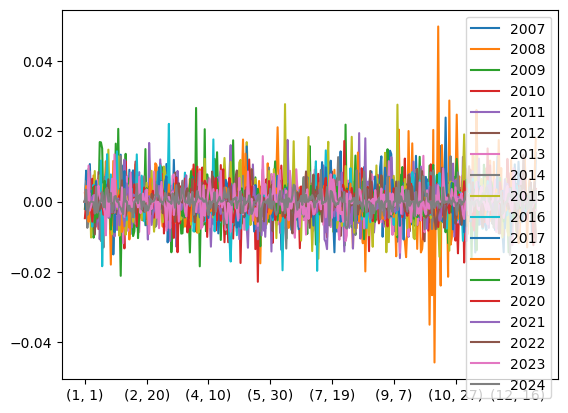

In [5]:
pivot_by_year.plot()

В нашей табличке с пивотом теперь есть колонка с номером месяца и колонка с номером дня месяца - обе входят в индекс - а также колонка для каждого года, в которую записан размер тела свечи с соответствующим знаком в этот день этого месяца этого года.
В целом, данные уже можно проанализировать на корреляцию
Давайте полюбопытствуем


In [6]:
import scipy

correlation_matrix = pivot_by_year.corr().dropna(how='all').dropna(axis=1, how='all')
correlation_matrix.head(50)

,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
2007,1.000000,0.002944,-0.055843,0.002510,0.067118,0.057823,-0.035401,0.075359,0.050010,0.033396,0.096752,-0.074145,0.069178,-0.039990,-0.043799,0.046956,-0.048390,0.016119
2008,0.002944,1.000000,-0.017652,-0.074004,-0.052249,0.039465,-0.108465,0.055302,-0.036778,-0.035105,-0.026773,0.053120,0.001936,-0.046788,-0.022937,-0.004745,0.061038,0.052615
2009,-0.055843,-0.017652,1.000000,-0.040525,0.039918,0.094357,0.003535,-0.010312,0.083169,-0.027339,-0.043981,0.044386,-0.045769,0.011695,0.001194,0.011490,-0.063976,0.020377
2010,0.002510,-0.074004,-0.040525,1.000000,0.004302,-0.025055,-0.044423,0.077742,-0.110329,0.090211,-0.022894,-0.006997,-0.019607,0.084933,-0.018337,0.081970,0.059614,-0.038605
2011,0.067118,-0.052249,0.039918,0.004302,1.000000,0.009957,0.007448,0.027131,-0.036934,-0.005583,0.021188,0.039962,-0.019594,-0.024925,0.074407,0.047781,-0.103987,-0.034696
2012,0.057823,0.039465,0.094357,-0.025055,0.009957,1.000000,0.052838,-0.001773,-0.055039,0.040836,-0.029879,0.101747,0.074351,-0.081055,-0.059909,0.016154,0.036684,-0.024635
2013,-0.035401,-0.108465,0.003535,-0.044423,0.007448,0.052838,1.000000,0.133495,0.025804,0.018845,-0.070325,0.060726,-0.013011,-0.080943,-0.009566,-0.036801,-0.080988,-0.026871
2014,0.075359,0.055302,-0.010312,0.077742,0.027131,-0.001773,0.133495,1.000000,-0.004096,-0.035499,0.030494,-0.021951,0.015140,0.086198,-0.014701,0.052707,-0.053321,-0.022444
2015,0.050010,-0.036778,0.083169,-0.110329,-0.036934,-0.055039,0.025804,-0.004096,1.000000,-0.069821,0.048140,-0.023085,-0.015407,0.127872,-0.109318,0.029108,-0.047323,0.036619
2016,0.033396,-0.035105,-0.027339,0.090211,-0.005583,0.040836,0.018845,-0.035499,-0.069821,1.000000,-0.081115,0.088312,-0.019559,0.071402,0.012509,-0.077696,0.071242,0.067793


Так, разумеется, ничего не понятно, поэтому мы возьмем верхний треугольник и посчитаем среднюю степень корреляции по годам:

In [7]:
upper_triangle = correlation_matrix.values[np.triu_indices(len(correlation_matrix), k=1)]
average_correlation = np.mean(upper_triangle)
average_correlation

np.float64(-4.088629063473157e-05)

очень близка к нулю, говорит.
Ну мы не удовлетворимся. Обратимся к z-трансформации Фишера, потому что усреднение корреляций - так себе идея

In [8]:
z_values = np.arctanh(upper_triangle)
mean_z = np.mean(z_values)
average_correlation = np.tanh(mean_z)
average_correlation

np.float64(-4.1349939144889094e-05)

Еще хуже. Ну окей, на протяжении всего года корреляция стремится к нулю за последние 20 лет
А давайте, может, поищем интервалы внутри года, где она к нулю не стремится?
<b>Сразу предупрежу: в этот момент мы начинаем подыскивать подтверждение нашей исходной теории после того, как она была опровергнута в целом. Это называется подгонка фактов под теорию, в народе известная, как cherry-picking</b>
<br>
Для начала избавимся от понятия месяц и день - ну не нужны они нам объективно. Просто пронумеруем день в году.

In [9]:
len(pivot_by_year)

366

In [10]:
pivot_reset = pivot_by_year.reset_index(drop=True)
pivot_reset.tail(10)

,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
356,0.00000,0.01227,0.00160,0.00872,-0.00111,0.00000,0.00000,0.00014,-0.00001,-0.00361,0.00019,0.00000,0.00000,0.00060,0.00295,0.00191,-0.00054,0.00000
357,0.00000,0.00439,-0.00275,-0.00524,0.00142,0.00000,0.00148,-0.00072,0.00157,-0.00258,0.00000,0.00000,-0.00196,-0.00076,0.00171,0.00052,0.00000,0.00048
358,-0.00116,-0.01300,0.00148,-0.00502,0.00000,-0.00221,-0.00067,-0.00169,-0.00101,0.00000,0.00000,-0.00198,-0.00055,-0.00071,-0.00231,0.00000,0.00000,-0.00219
359,0.00000,0.00221,0.00169,0.00000,0.00000,-0.00127,-0.00107,-0.00021,0.00004,0.00000,0.00031,-0.00265,0.00027,0.00106,0.00000,0.00000,-0.00187,-0.00170
360,0.00513,-0.00015,0.00000,0.00000,0.00198,0.00621,0.00143,-0.00314,0.00000,-0.00125,-0.00094,0.00645,-0.00116,0.00000,0.00000,-0.00062,0.00020,0.00406
361,-0.00113,0.00000,0.00000,-0.00076,0.00189,-0.00182,-0.00277,0.00000,0.00000,0.00097,0.00243,-0.00070,0.00013,0.00000,0.00320,0.00540,0.00151,-0.00256
362,-0.00931,0.00000,0.00118,-0.00171,-0.00238,0.00069,0.00000,0.00000,-0.00514,-0.00538,0.00030,-0.00041,0.00000,-0.00076,0.00021,-0.00523,-0.00161,0.00000
363,0.00000,0.00115,-0.00595,-0.01240,0.00185,0.00000,0.00000,-0.00219,0.00342,-0.00043,-0.00284,0.00000,0.00000,-0.00277,-0.00056,0.00010,-0.00036,0.00000
364,0.00000,0.00640,-0.00805,-0.00421,-0.00326,0.00000,-0.00113,0.00089,0.00285,0.00229,0.00000,0.00000,-0.00200,0.00227,-0.00044,0.00552,0.00000,-0.00037
365,0.01385,0.01795,0.00090,-0.01012,0.00000,-0.01141,-0.00237,0.00177,0.00170,0.00000,0.00000,0.00029,0.00293,0.00365,0.00130,0.00000,0.00000,0.00289


In [11]:
len(pivot_reset)

366

Определим фитнесс-функцию как среднюю корреляцию суб-матрицы с некоторого одного дня по некоторый другой. По Фишеру.

In [12]:
def fitness_function(df, start_index, end_index):
    # Slice the DataFrame based on the given indices
    df_slice = df.iloc[start_index:end_index+1]
    
    # Calculate the correlation matrix
    corr_matrix = df_slice.corr().dropna(how='all').dropna(axis=1, how='all')
    
    # Extract the upper triangle of the correlation matrix
    upper_triangle = corr_matrix.values[np.triu_indices(len(corr_matrix), k=1)]
        # Apply Fisher's z-transformation
    z_values = np.arctanh(upper_triangle)
    
    # Calculate the mean of z-values
    mean_z = np.mean(z_values)
    
    # Transform back to correlation coefficient
    average_corr = np.tanh(mean_z)
    
    return average_corr

Протестируем нашу фитнес-функцию на уже известной величине: средней корреляции от начала и до конца года

In [23]:
fitness_function(pivot_reset, 0, len(pivot_reset))

np.float64(0.27343540369354324)

Совпало, отлично. Давайте накрутим оптимизацию, которая выберет нам оптимальные значения индексов?

In [20]:
import pandas as pd
import numpy as np

def find_optimal_intervals(df, fitness_function):
    n = len(df)
    max_interval_size = n // 2
    best_intervals = []
    best_fitness = 0

    for interval_size in range(2, max_interval_size + 1):
        intervals = []
        for start in range(0, n - interval_size + 1):
            end = start + interval_size - 1
            fitness = fitness_function(df, start, end)
            intervals.append((start, end, fitness))
        
        intervals.sort(key=lambda x: x[2], reverse=True)
        selected = []
        
        for interval in intervals:
            if not any(overlaps(interval, selected_interval) for selected_interval in selected):
                selected.append(interval)
        
        avg_fitness = sum(interval[2] for interval in selected) / len(selected)
        if avg_fitness > best_fitness:
            best_fitness = avg_fitness
            best_intervals = selected

    # Convert the best intervals to a DataFrame
    result_df = pd.DataFrame(best_intervals, columns=['Start', 'End', 'Fitness'])
    result_df['Length'] = result_df['End'] - result_df['Start'] + 1
    result_df = result_df.sort_values('Start').reset_index(drop=True)

    return result_df

def overlaps(interval1, interval2):
    return max(interval1[0], interval2[0]) <= min(interval1[1], interval2[1])

def find_highest_correlation_interval(df, ff, min_interval):
    n = len(df)
    best_start = 0
    best_end = n - 1
    best_correlation = ff(df, best_start, best_end)

    for start in range(n - min_interval):
        for end in range(start + min_interval, n):
            correlation = ff(df, start, end)
            if not np.isnan(correlation) and (correlation > best_correlation or np.isnan(best_correlation)):
                best_correlation = correlation
                best_start = start
                best_end = end

    return best_start, best_end, best_correlation


Тут, собственно, реализован алгоритм поиска непересекающихся интервалов, жадная вариация.
Он возвращает набор интервалов, отсортированный по убыванию корреляции за все годы.
Натравим его на нашу табличку, попросим :

In [21]:
intervals = find_optimal_intervals(pivot_reset, fitness_function)
# Sort the DataFrame by the 'Fitness' column in descending order
sorted_df = intervals.sort_values('Fitness', ascending=False)
sorted_df.head(10)

,Start,End,Fitness,Length
9,59,63,0.273435,5
2,18,22,0.235909,5
50,328,332,0.185448,5
26,166,170,0.163696,5
55,358,362,0.152424,5
52,338,342,0.127026,5
45,297,301,0.124502,5
3,23,27,0.118309,5
20,130,134,0.108288,5
47,307,311,0.106851,5


In [24]:
best_start, best_end, best_correlation = find_highest_correlation_interval(pivot_reset, fitness_function, 4)
print(f"Best interval: [{best_start}, {best_end}] with correlation: {best_correlation}")

Best interval: [59, 63] with correlation: 0.27343540369354324


Неутешительный итог: даже попытки выдать желаемое за действительное не наловили нам ни одного интервала с корреляцией выше 0.21 за последние 20 лет.
Давайте попробуем упростить и забьем на все выходные и прочие нормализации. Просто возьмем последовательности, как они есть.

In [17]:
df_reset_idx = df_trimmed.reset_index()
df_reset_idx['Year'] = df_reset_idx['Date'].dt.year
year_dfs = {year: group['MOVE'].reset_index(drop=True) for year, group in df_reset_idx.groupby('Year')}
df_final = pd.concat(year_dfs, axis=1).fillna(0.0)
df_final.tail(10)

,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
255,-0.00116,0.01227,0.00169,0.00204,-0.00219,0.00461,-0.00025,0.00020,-0.00261,-0.00085,-0.00566,-0.00079,0.00231,0.00145,0.00295,0.01324,-0.00083,0.00405
256,0.00513,0.00439,0.00118,0.00872,-0.00111,0.00029,0.00685,0.00014,-0.00001,-0.00361,0.00488,-0.00160,0.00258,0.00040,0.00171,0.00191,0.00318,0.00253
257,-0.00113,-0.01300,-0.00595,-0.00524,0.00142,0.00623,0.00552,-0.00072,0.00157,-0.00258,0.00019,-0.00198,-0.00196,0.00060,-0.00231,0.00052,-0.00054,-0.00254
258,-0.00931,0.00221,-0.00805,-0.00502,0.00198,-0.00221,0.00148,-0.00169,-0.00101,-0.00125,0.00031,-0.00265,-0.00055,-0.00076,0.00320,-0.00062,-0.00187,0.00048
259,0.01385,-0.00015,0.00090,-0.00076,0.00189,-0.00127,-0.00067,-0.00021,0.00004,0.00097,-0.00094,0.00645,0.00027,-0.00071,0.00021,0.00540,0.00020,-0.00219
260,0.00000,0.00115,0.00000,-0.00171,-0.00238,0.00621,-0.00107,-0.00314,-0.00514,-0.00538,0.00243,-0.00070,-0.00116,0.00106,-0.00056,-0.00523,0.00151,-0.00170
261,0.00000,0.00640,0.00000,-0.01240,0.00185,-0.00182,0.00143,-0.00219,0.00342,-0.00043,0.00030,-0.00041,0.00013,-0.00076,-0.00044,0.00010,-0.00161,0.00406
262,0.00000,0.01795,0.00000,-0.00421,-0.00326,0.00069,-0.00277,0.00089,0.00285,0.00229,-0.00284,0.00029,-0.00200,-0.00277,0.00130,0.00552,-0.00036,-0.00256
263,0.00000,0.00000,0.00000,-0.01012,0.00000,-0.01141,-0.00113,0.00177,0.00170,0.00000,0.00000,0.00000,0.00293,0.00227,0.00000,0.00000,0.00000,-0.00037
264,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-0.00237,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00365,0.00000,0.00000,0.00000,0.00289


И теперь воспользуемся теми же функциями, которые у нас уже есть

In [18]:
fitness_function(df_final, 0, len(df_final))

np.float64(0.0022694291254902045)

In [19]:
best_start, best_end, best_correlation = find_highest_correlation_interval(df_final, fitness_function, 5)
print(f"Best interval: [{best_start}, {best_end}] with correlation: {best_correlation}")

Best interval: [259, 264] with correlation: 1.0


Тут получилось еще хуже, ожидаемо (нули в конце)